In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, GridSearchCV

<h2> 3.6 Feature importance (Advance Features and Basic Features) </h2>
<h3> 3.6.1 Load the  feature engineering datasets </h3>

In [2]:
if os.path.isfile('nlp_features_train.csv'):
    df_adv_feats = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df_basic_feats = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [3]:
df_adv_feats.shape, df_basic_feats.shape

((404290, 21), (404290, 17))

In [7]:
df_adv_feats.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

In [8]:
df_basic_feats.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

In [4]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069

df_adv_feats['question1'] = df_adv_feats['question1'].apply(lambda x: str(x))
df_adv_feats['question2'] = df_adv_feats['question2'].apply(lambda x: str(x))

In [5]:
#Taking the processed texts
df_ques = df_adv_feats[['question1','question2']]

#Extracting only the basic and advance features and nothing else
df_adv = df_adv_feats.iloc[0:,6:]
df_basic = df_basic_feats.iloc[0:,6:]

labels = df_adv_feats[['is_duplicate']]

<h4> 3.6.1.1 Combine all the dataframes containing questions, basic and advance features </h4>

In [11]:
#Merge into one single dataframe and save it for later use.
dt_df = pd.concat([df_ques, df_basic, df_adv, labels],axis=1)
dt_df.to_csv('all_features.csv', index=False)


<h4> 3.6.1.2 Load and split the all_features dataset randomly in 70:30 ratio. (Split and then encode) </h4>

In [7]:
#Load the dataset.  Filling the null values with ' '
df = pd.read_csv('all_features.csv').fillna('')

X = df.drop(['is_duplicate'], axis=1)
y = df[['is_duplicate']]

#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

<h4> 3.6.1.3 EDA using Normalised histogram of character count in questions </h4>

Mean-Train 59.99, STD-Train 32.09, 
Mean-Test 59.95, STD-Test 32.19, 
Max-Train 1173.00, Max-Test 1173.00


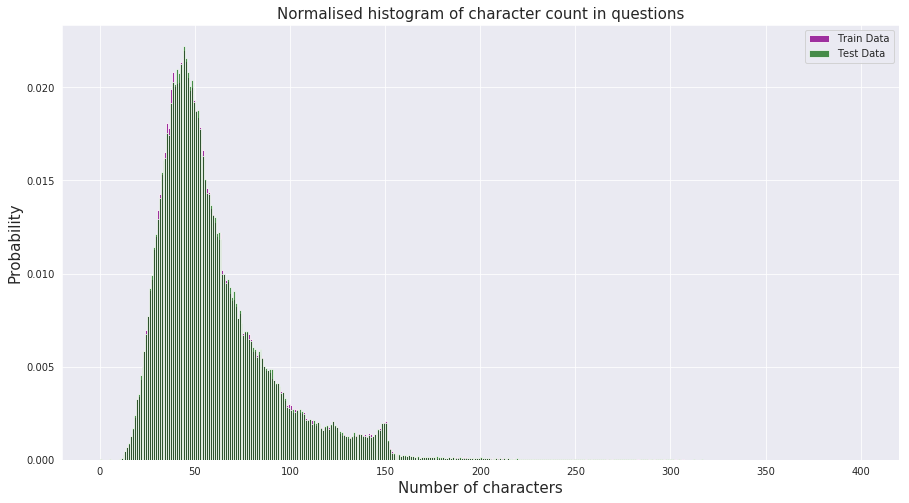

In [16]:
# https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/notebook
train_qs = pd.Series(X_train['question1'].tolist() + X_train['question2'].tolist()).astype(str)
test_qs = pd.Series(X_test['question1'].tolist() + X_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

sns.set_style('darkgrid')
plt.figure(figsize=(15, 8))

plt.hist(dist_train, bins=400, range=[0, 400], color='darkmagenta', normed=True, alpha = 0.8, label='Train Data')

plt.hist(dist_test, bins=400, range=[0, 400], color='darkgreen', normed=True, alpha=0.7, label='Test Data')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Mean-Train {:.2f}, STD-Train {:.2f}, \nMean-Test {:.2f}, STD-Test {:.2f}, \nMax-Train {:.2f}, Max-Test {:.2f}'.format(dist_train.mean(), 
                                                                                                                             dist_train.std(), 
                                                                                                                             dist_test.mean(), 
                                                                                                                             dist_test.std(), 
                                                                                                                             dist_train.max(), 
                                                                                                                             dist_test.max()))

<h4>Observations: </h4>

- It can be seen that the length of characters of most questions are somewhere between 20 and 150. The median length of questions is somewhere around 55. This means most of the questions pair that are present are highly concentrated in the region of 50 characters.

- By looking at the distribution of character count in both the train and test set, it can be seen that there is almost a perfect overlap of both the distributions. 

- The mean values of train and test set are extremely close to each other, also the STD values are extremely close. 

- The maximum length of characters for the questions present in both the train and test set is just under 1200. 

- Also, if noticed carefully, there is a very sudden drop in character counts beyond the 150 mark on the X-axis. There are a very few number of people who actually writes questions which are greater than 200 characters in length.

- The disitribution is skewed towards the lef side.


<h4> 3.6.1.4 EDA using Normalised histogram of word count in questions </h4>

Mean-Train 12.71, STD-Train 6.72, 
Mean-Test 12.70, STD-Test 6.77, 
Max-Train 271.00, Max-Test 271.00


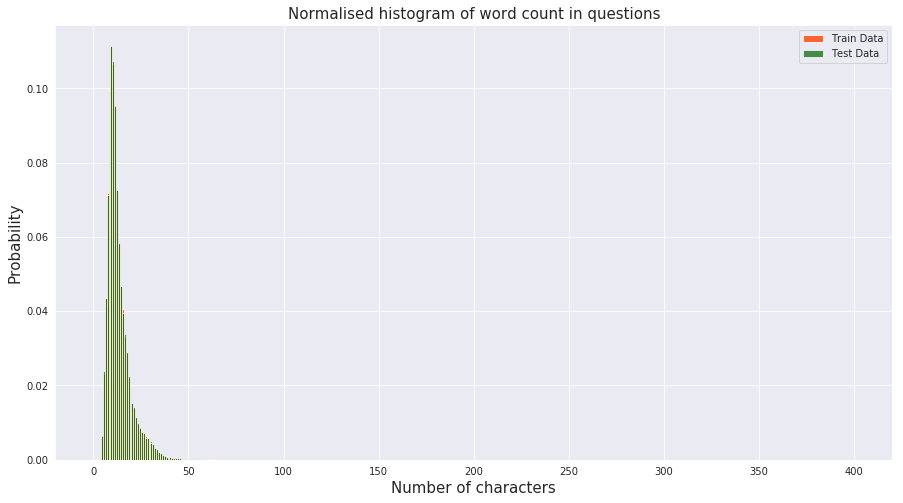

In [18]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 8))

plt.hist(dist_train, bins=400, range=[0, 400], color='orangered', normed=True, alpha = 0.8, label='Train Data')
plt.hist(dist_test, bins=400, range=[0, 400], color='darkgreen', normed=True, alpha=0.7, label='Test Data')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('Mean-Train {:.2f}, STD-Train {:.2f}, \nMean-Test {:.2f}, STD-Test {:.2f}, \nMax-Train {:.2f}, Max-Test {:.2f}'.format(dist_train.mean(), 
                                                                                                                             dist_train.std(), 
                                                                                                                             dist_test.mean(), 
                                                                                                                             dist_test.std(), 
                                                                                                                             dist_train.max(), 
                                                                                                                             dist_test.max()))

<h4> Observations:</h4>

- Here also the same thing can be noticed. The distribution of word counts for both the train and test data looks very similar. They are nearly perfectly overlapping with some very slight differences. 
- Both the distributions are skewed towards the left.
- The word count for all the questions varies roughly between 5 to 45. 
- The median word count for the questions in both train and test data are somewhere around the 13 mark. This means most users have written questions which has 10-15 words.
- The maximum word count present in the questions of both train and test data is slightly under 300. Extremely few questions are there which goes to upto a word count of 271. Most of them are present in the dense region around the 13-15 mark.

<h3> 3.6.2 Using random forest for feature importance </h3>
<h4> 3.6.2.1 Load the dataset with all engineered features </h4>

In [33]:
df = pd.read_csv('all_features.csv').fillna('')
X = df.drop(['is_duplicate','question1','question2'], axis=1) #This X contains only the engineered features
y = np.array(df[['is_duplicate']]).ravel()

X.head()

freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
0          1          1     66     57          14          12         10.0   
1          4          1     51     88           8          13          4.0   
2          1          1     73     59          14          10          4.0   
3          1          1     50     65          11           9          0.0   
4          3          1     76     39          13           7          2.0   

   word_Total  word_share  freq_q1+q2  ...   ctc_max  last_word_eq  \
0        23.0    0.434783           2  ...  0.785709           0.0   
1        20.0    0.200000           5  ...  0.466664           0.0   
2        24.0    0.166667           2  ...  0.285712           0.0   
3        19.0    0.000000           2  ...  0.000000           0.0   
4        20.0    0.100000           4  ...  0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   
2            1.0           4.0      12.0               66                66   
3            0.0           2.0      12.0               36                36   
4            1.0           6.0      10.0               67                47   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  
2          54                  54              0.166667  
3          35                  40              0.039216  
4          46                  56              0.175000  

[5 rows x 26 columns]

In [34]:
X.shape, y.shape

((404290, 26), (404290,))

<h4> 3.6.2.2 Random Forest Classifier with hyperparameter tuning </h4>

In [41]:
from sklearn.ensemble import RandomForestClassifier

def get_best_param(X, y):
    tuned_parameters = {'max_depth': [5, 10, 25, 50, 100, 200], 
                        'min_samples_split' : [5, 10, 50, 100],
                       'n_estimators': [50, 100, 200]}
    base_estimator = RandomForestClassifier(criterion='gini', random_state=0) 
    rsearch_cv = RandomizedSearchCV(estimator=base_estimator, 
                                    param_distributions=tuned_parameters, 
                                    n_iter=30, cv=3,
                                    verbose = 2,
                                    scoring='neg_log_loss', n_jobs=-1)
    rsearch_cv.fit(X, y)
    print("Best estimator obtained from CV data: \n", rsearch_cv.best_estimator_)
    print("Best Score : ", rsearch_cv.best_score_)    
    return (rsearch_cv)


def top_features(model, n):
    '''Get the most important features for the given input vector.'''
    features=model.feature_importances_
    top_features_index = (-features).argsort() #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_features = np.take(X.columns, top_features_index[:n])

    #Plot the feature importance for all the features
    x = X.columns
    y = features

    plt.figure(figsize=(15, 8))
    plt.title ("VISUALIZING FEATURE IMPORTANCES")
    plt.ylabel('Feature names')
    plt.xlabel('Feature importance score')
    sns.barplot(y, x, orient='h', palette = 'dark')
    plt.show()
    
    print("The top {} important features are.\n".format(n))
    print(list(top_features))




In [36]:
randomCV = get_best_param(X, y)
model = randomCV.best_estimator_
model.fit(X,y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 29.4min finished


Best estimator obtained from CV data: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Score :  -0.33684791217839355


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

<h4> 3.6.2.3 Top 15 most important features amongst all the engineered features </h4>

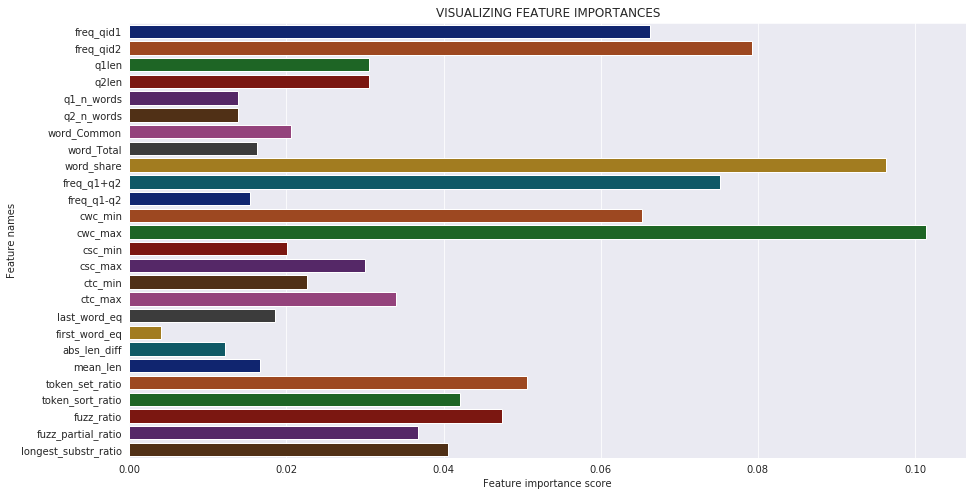

The top 15 important features are.

['cwc_max', 'word_share', 'freq_qid2', 'freq_q1+q2', 'freq_qid1', 'cwc_min', 'token_set_ratio', 'fuzz_ratio', 'token_sort_ratio', 'longest_substr_ratio', 'fuzz_partial_ratio', 'ctc_max', 'q1len', 'q2len', 'csc_max']


In [42]:
top_features(model, n=15)

<h4> Observation </h4>

-  It can be observed that, `cwc_max`, `freq_q1+q2`, `word_share`, `freq_qid2`, `freq_qid1`, `csc_max`, `token_sort_ratio`, `cwc_min`, `last_word_eq`, `q2len`, `token_set_ratio`, `abs_len_diff`, `longest_substr_ratio`, `fuzz_ratio`, `word_Total` are the top 15 most important features out of all the basic and advance features that we have extracted. 

- Using just the engineered features and nothing else, our model gave us a log loss value of 0.3368, which is pretty good as compared to some of the other models we have trained later. 

- `word_Common`, `fuzz_partial_ratio`, `csc_min`, `q1len`, `first_word_eq`, `freq_q1-q2`, `ctc_min`, `ctc_max`, `mean_len`, `q1_n_words`, `q2_n_words` are our 11 least important features. However, we will keep them as of now and use them to build our models and see results do we get.

<h2> 4 Featurizing text data with tfidf weighted word-vectors </h2>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

<h4> 4.1 Building TFIDF Weighted W2V models using the train and test data (Using spacy) </h4>

In [31]:
# avoid decoding problemshttp://34.73.115.2:8888/notebooks/3.Q_Mean_W2V.ipynb#
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [33]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [34]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

CPU times: user 11.6 s, sys: 184 ms, total: 11.7 s
Wall time: 11.7 s


In [50]:
!pip install -U spacy-lookups-data

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 93.8 MB 73 kB/s s eta 0:00:01
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.3.2-py2.py3-none-any.whl size=93809368 sha256=c577ff3f7c895b7c4faace65400bae4965c7c5160d6ea003aba268d05356911b
  Stored in directory: /home/hirak_sen_roy/.cache/pip/wheels/72/27/21/0f0d6ff54af929f872f8b9b13f28a84004871da2b35d4d9f3e
Successfully built spacy-lookups-data


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [53]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz --no-deps

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.0 MB 4.1 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019926 sha256=4d2c3fe42612b801c015f01abd26b0cd37c7341a1ef3ee6bbfdfd98f5d1905ff
  Stored in directory: /home/hirak_sen_roy/.cache/pip/wheels/e9/c2/77/d76a6455dc9ecb77b3328ef3d0fc5af7afcf5a1f19e3fa042e
Successfully built en-core-web-sm


In [35]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [36]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)




  0%|          | 0/404290 [00:00<?, ?it/s]

  0%|          | 9/404290 [00:00<1:21:25, 82.74it/s]

  0%|          | 18/404290 [00:00<1:22:02, 82.13it/s]

  0%|          | 27/404290 [00:00<1:21:24, 82.77it/s]

  0%|          | 36/404290 [00:00<1:22:06, 82.06it/s]

  0%|          | 44/404290 [00:00<1:22:49, 81.35it/s]

  0%|          | 52/404290 [00:00<1:23:27, 80.73it/s]

  0%|          | 61/404290 [00:00<1:21:46, 82.39it/s]

  0%|          | 71/404290 [00:00<1:19:33, 84.68it/s]

  0%|          | 80/404290 [00:00<1:19:51, 84.36it/s]

  0%|          | 89/404290 [00:01<1:21:03, 83.12it/s]

  0%|          | 98/404290 [00:01<1:19:29, 84.74it/s]

  0%|          | 107/404290 [00:01<1:20:47, 83.38it/s]

  0%|          | 117/404290 [00:01<1:19:22, 84.87it/s]

  0%|          | 126/404290 [00:01<1:19:32, 84.69it/s]

  0%|          | 135/404290 [00:01<1:19:22, 84.87it/s]

  0%|          | 145/404290 [00:01<1:17:53, 86.48it/s]

  0%|          | 154/404290 [00:01<1:19:09, 85.10it/s]

  0%|         

In [37]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)



  0%|          | 0/404290 [00:00<?, ?it/s]

  0%|          | 10/404290 [00:00<1:13:06, 92.16it/s]

  0%|          | 19/404290 [00:00<1:14:00, 91.04it/s]

  0%|          | 29/404290 [00:00<1:13:32, 91.62it/s]

  0%|          | 38/404290 [00:00<1:14:29, 90.44it/s]

  0%|          | 47/404290 [00:00<1:14:41, 90.21it/s]

  0%|          | 56/404290 [00:00<1:15:02, 89.77it/s]

  0%|          | 66/404290 [00:00<1:14:42, 90.18it/s]

  0%|          | 76/404290 [00:00<1:14:50, 90.02it/s]

  0%|          | 85/404290 [00:00<1:15:43, 88.97it/s]

  0%|          | 94/404290 [00:01<1:16:35, 87.95it/s]

  0%|          | 104/404290 [00:01<1:15:22, 89.37it/s]

  0%|          | 113/404290 [00:01<1:15:18, 89.45it/s]

  0%|          | 122/404290 [00:01<1:15:49, 88.85it/s]

  0%|          | 132/404290 [00:01<1:14:31, 90.38it/s]

  0%|          | 141/404290 [00:01<1:14:49, 90.02it/s]

  0%|          | 151/404290 [00:01<1:14:40, 90.20it/s]

  0%|          | 161/404290 [00:01<1:14:02, 90.97it/s]

  0%|       

In [38]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [39]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [40]:
# dataframe of nlp features
df1.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   
2   2             0  0.399992  0.333328  0.399992  0.249997  0.399996   
3   3             0  0.000000  0.000000  0.000000  0.000000  0.000000   
4   4             0  0.399992  0.199998  0.999950  0.666644  0.571420   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   
2  0.285712           0.0            1.0           4.0      12.0   
3  0.000000           0.0            0.0           2.0      12.0   
4  0.307690           0.0            1.0           6.0      10.0   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   
2               66                66          54                  54   
3               36                36          35                  40   
4               67                47          46                  56   

   longest_substr_ratio  
0              0.982759  
1              0.596154  
2              0.166667  
3              0.039216  
4              0.175000

In [41]:
# data before preprocessing 
df2.head()

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0   0          1          1     66     57          14          12   
1   1          4          1     51     88           8          13   
2   2          1          1     73     59          14          10   
3   3          1          1     50     65          11           9   
4   4          3          1     76     39          13           7   

   word_Common  word_Total  word_share  freq_q1+q2  freq_q1-q2  
0         10.0        23.0    0.434783           2           0  
1          4.0        20.0    0.200000           5           3  
2          4.0        24.0    0.166667           2           0  
3          0.0        19.0    0.000000           2           0  
4          2.0        20.0    0.100000           4           2

In [42]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

0           1           2           3           4           5   \
0  -19.025071   30.407702 -131.289405 -132.103401   52.904238   90.266863   
1 -107.513394   76.485828 -138.399415 -128.175294  -29.019106   74.449380   
2  -98.370838 -105.838490  -85.035027 -135.944165   63.274703   57.573161   
3   11.846887  -69.441899 -104.972933  -33.480250   26.744676  142.427759   
4  -77.952287    2.390030 -191.634528 -225.280346  141.381444   15.397884   

          6           7          8           9   ...          86          87  \
0  18.937711   -5.182972 -61.376455 -151.893303  ...  -87.327558  102.562218   
1  24.753921   16.162431  -4.345510  -35.754816  ... -152.350909   56.232684   
2   3.784962   40.183856  27.080293  -59.880297  ... -111.718713  125.991656   
3   8.649163   38.479151 -24.331226  -46.316330  ...   65.919951   24.812937   
4 -38.772814  102.841479  84.803197 -209.916705  ... -134.909378  173.287175   

           88          89          90          91          92          93  \
0   23.157324   73.647913  -16.079638   -2.087055  142.494750 -140.396981   
1  112.224383   68.668525 -132.461794    5.614578   63.443419 -125.084111   
2   39.411461   91.816011  -55.469449   38.768507   -7.379202 -123.235320   
3  -71.534835   27.133132   50.103040  -88.737473   31.376285  -66.085595   
4   36.020212  135.444078  -32.498977  150.990699  109.611363 -171.882083   

          94          95  
0  14.361558  -22.044214  
1 -74.360627   23.123066  
2  -2.688627   -5.207624  
3 -84.347588    7.047811  
4 -66.312017 -162.713978  

[5 rows x 96 columns]

In [43]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

0          1           2           3          4           5   \
0 -28.113366  14.071278 -110.017217 -121.012769  55.654943   97.055868   
1 -31.698329  80.247892 -171.282319 -224.183353 -51.760660  100.503521   
2 -52.978780   7.761064 -145.027095  -74.633728   5.409303   36.514726   
3 -28.516060  22.681442 -119.779503  -58.153847  10.842536   90.849295   
4 -28.920556 -47.628024  -90.717242  -73.382467  69.571517   81.649125   

           6          7          8           9   ...          86          87  \
0   36.225522  -8.014750 -46.942513 -135.547524  ...  -63.734823   95.815095   
1 -133.589200  -1.417114 -12.462783  -41.630977  ... -148.637857  109.711111   
2  -83.806991  77.081297  27.657254   21.315004  ... -122.836905  130.318532   
3   -0.593641  -6.998696  20.539878   -5.490560  ...  -88.775480   82.716187   
4  -24.962595  47.079589  -1.234543 -100.526938  ...   17.840809   42.080071   

          88         89          90         91          92          93  \
0  13.500241  89.460430   -3.119270 -28.378391  103.745101 -118.916583   
1  62.538758  72.154383 -137.756539   5.251177   63.611633 -165.109514   
2  44.760436   4.675818  -56.794321  -6.889840   32.630609  -11.958579   
3 -63.615549  -4.947012  -58.495736 -14.816066  100.331751   11.372287   
4 -60.014182  19.771544  -13.976709   8.539354   75.278647  -77.371831   

          94         95  
0 -14.315183 -14.894133  
1 -94.521665  25.105438  
2 -34.432988  28.749938  
3 -65.016258 -20.112199  
4  24.389921 -26.920907  

[5 rows x 96 columns]

In [44]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [45]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

<h2> 5 Featurizing text data with tfidf weighted word-vectors </h2>

<h3> 5.1 Get tfidf feature representation </h3>

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Merge questions
questions = list(X_train['question1']) + list(X_train['question2'])

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(questions)

In [44]:
%%time

import scipy
from scipy.sparse import hstack
import pickle


q1_vectors_train = tf_idf_object.transform(X_train['question1'])
q2_vectors_train = tf_idf_object.transform(X_train['question2'])

q1_vectors_test = tf_idf_object.transform(X_test['question1'])
q2_vectors_test = tf_idf_object.transform(X_test['question2'])
    

CPU times: user 11.3 s, sys: 8 ms, total: 11.3 s
Wall time: 11.3 s


In [46]:
feat_vectors_train = X_train.drop(['question1','question2'],axis=1)
feat_vectors_test = X_test.drop(['question1','question2'],axis=1)

In [45]:
q1_vectors_train.shape, q2_vectors_train.shape, q1_vectors_test.shape, q2_vectors_test.shape

((283003, 73560), (283003, 73560), (121287, 73560), (121287, 73560))

In [51]:
data_matrix_train = hstack((q1_vectors_train, q2_vectors_train, feat_vectors_train.values))
data_matrix_test = hstack((q1_vectors_test, q2_vectors_test, feat_vectors_test.values))
print("Number of TFIDF features in final train dataframe  :", data_matrix_train.shape[1])
print("Number of TFIDF features in final test dataframe  :", data_matrix_test.shape[1])

Number of TFIDF features in final train dataframe  : 147146
Number of TFIDF features in final test dataframe  : 147146


In [53]:
#Finally save the sparse matrices for later use.
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(data_matrix_train, file)

with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(data_matrix_test, file)

with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)